In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
import os
import seaborn as sns

2023-04-04 22:03:48.320084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set up folder
SIZE = 512
p = os.path.abspath('.')
output_dir = os.path.join(p, f'{SIZE}')
os.mkdir(output_dir)
print(output_dir)

/home/art_usr/source_code/CFU_counter/512


In [3]:
# Resize images and write them into folder
for file in glob.glob('./Thresholded/*'):
	filename = file.split('/')[-1]
	img = cv2.imread(file, cv2.IMREAD_COLOR)
	img = cv2.resize(img, (SIZE,SIZE))
	new_name = os.path.join(output_dir, filename)
	cv2.imwrite(new_name, img)

In [4]:
# Read filenames in the folder
image_names = []
labels = []

for file in glob.glob(f'{output_dir}/*.jpg'):
	filename = file.split('/')[-1]
	num_colonies = int(filename.split('-')[2].strip().split('.')[0])
	if num_colonies == 0:
		labels.append(0)
	else:
		labels.append(1)
	image_names.append(filename)

image_names = np.array(image_names)
labels = np.array(labels)

In [5]:
#  Get two arrays with filenames for positive and negative images
pos_im_files = [image_names[i] for i in range(image_names.shape[0]) if labels[i]]
pos_im_files = np.array(pos_im_files)
neg_im_files = [image_names[i] for i in range(image_names.shape[0]) if not labels[i]]
neg_im_files = np.array(neg_im_files)
num_pos = pos_im_files.shape[0]
num_neg = neg_im_files.shape[0]
print(f'There are {num_pos} images with bacteria and {num_neg} without')

There are 366 images with bacteria and 3986 without


In [6]:
#  There are ~10x positive than negative.
#  For initital training let's get all positive and equal number of negative
#  For that:
#  (1) Index files of randomly selected negative images
np.random.seed(0) # For reproducibility
idx = np.random.choice(np.arange(neg_im_files.shape[0]), num_pos, replace = False)
#  (2) Apply this index to the array of image names
neg_selected_files = neg_im_files[idx]
#  (3) Make a full set of file names, with X and y, not split into train.test yet
X_files = np.concatenate((pos_im_files,neg_selected_files), axis =0)
y = np.concatenate((np.ones(num_pos), np.zeros(neg_selected_files.shape[0])))
print(X_files.shape, y.shape)

(732,) (732,)


In [7]:
# Now shuffle the names
num_datapoints = X_files.shape[0]
indices = np.arange(num_datapoints)
shuffled_indices = np.random.permutation(indices)
X_shuffled_files = X_files[shuffled_indices]
y_shuffled = y[shuffled_indices]

In [8]:
# Read the actual files:
images = []
for file_name in X_shuffled_files:
    file = os.path.join(output_dir, file_name)
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    images.append(img)

X_shuffled = np.array(images)

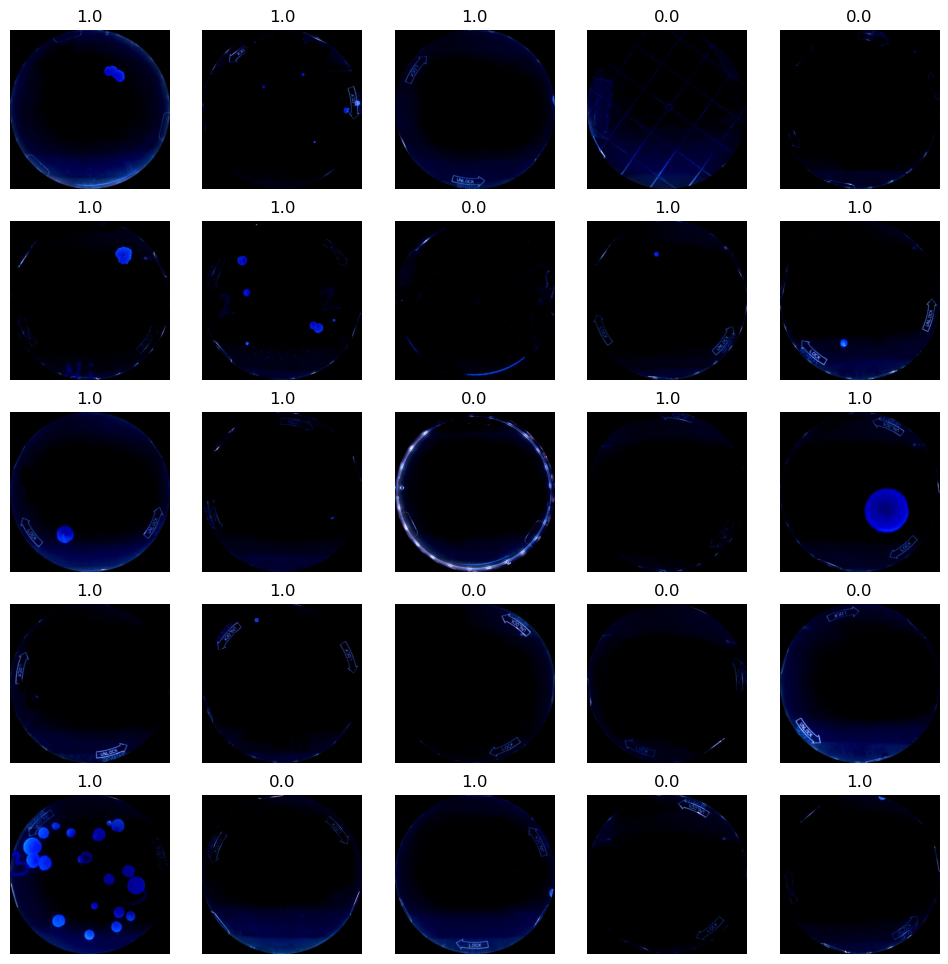

In [9]:
# Visualize first 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

row = 0
label_name = "Shirt predicted as coat"
axs[row,0].set_title(label_name)
axs[row,0].axis('off')

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = 5*i+j
    image = cv2.cvtColor(X_shuffled[idx], cv2.COLOR_HSV2RGB)
    axs[i,j].imshow(image)
    axs[i,j].set_title(y_shuffled[idx])
    axs[i,j].axis('off')

plt.show()


In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D

# Define the image size and input_shape
img_size = (SIZE, SIZE)
input_shape = (*img_size, 3)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=42)

# One-hot encode the labels
num_classes = max(labels) + 1
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.AUTOTUNE)

2023-04-04 22:07:34.740761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 22:07:34.742854: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
# Define the EfficientNet model
base_model = EfficientNetB0(weights='imagenet')
feature_extractor = Sequential()
img_size = (SIZE, SIZE)
input_shape = (*img_size, 3)

# Define the EfficientNet model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten()
])

# Freeze the base model's layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = False

In [18]:
#Now, let us use features from convolutional network for RF
X_for_RF = model.predict(X_train) #This is out X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

y_train_dense = tf.argmax(y_train, axis=1)
y_test_dense = tf.argmax(y_val, axis=1)
# Train the model on training data
RF_model.fit(X_for_RF, y_train_dense) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = model.predict(X_val)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test_dense, prediction_RF))

5/5 [==============================] - 51s 10s/step
Accuracy =  0.8435374149659864


<AxesSubplot: >

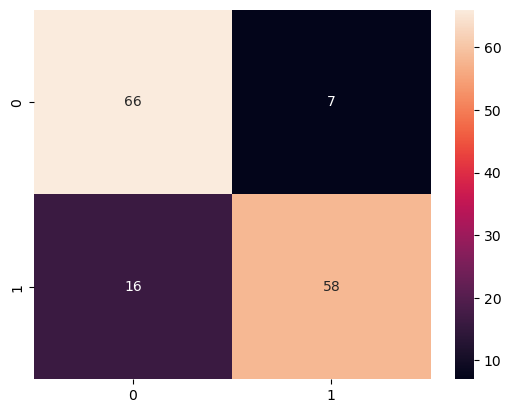

In [19]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_dense, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

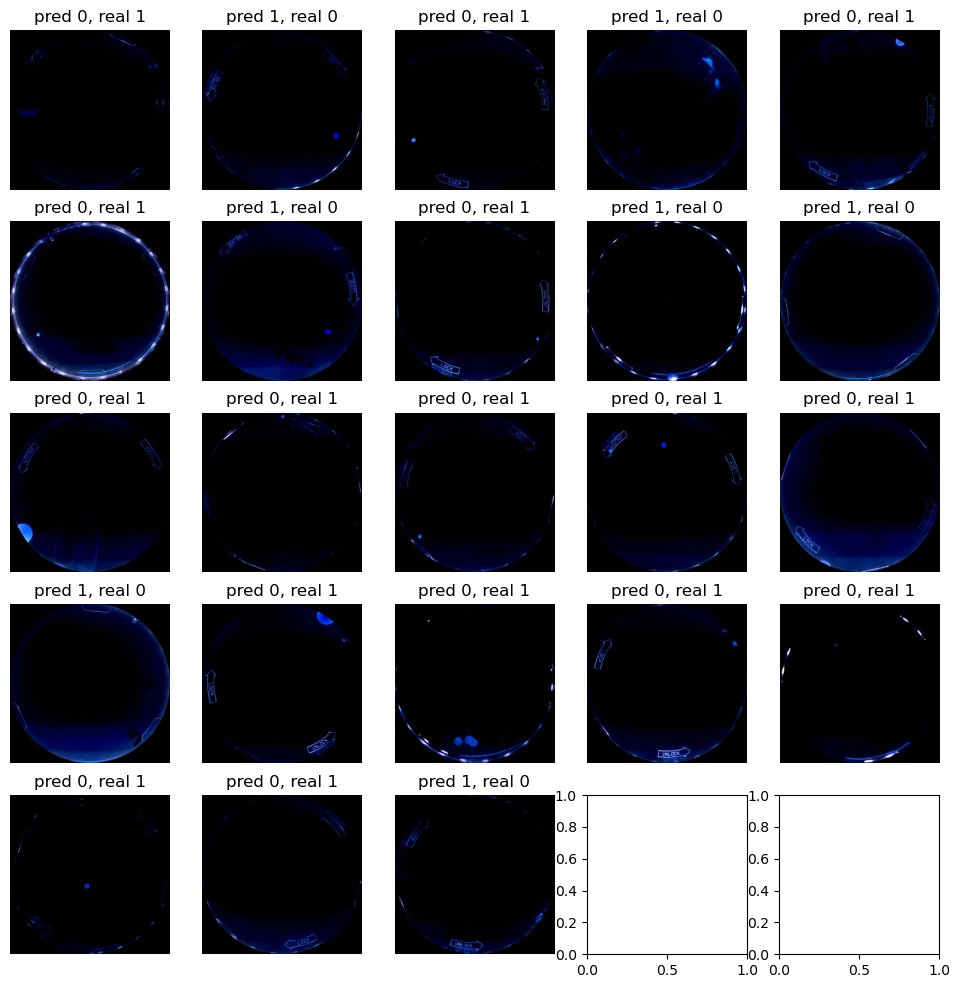

In [20]:
# Visualize 25 mistakes
error_idx = [i for i, rslt in enumerate(y_test_dense) if (rslt + prediction_RF[i] == 1)]

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    if (5*i+j) < len(error_idx):
        idx = error_idx[5*i+j]
        image = cv2.cvtColor(X_val[idx], cv2.COLOR_HSV2RGB)
        axs[i,j].imshow(image)
        axs[i,j].set_title(f'pred {int(prediction_RF[idx])}, real {int(y_test_dense[idx])}')
        axs[i,j].axis('off')

plt.show()